In [5]:
import numpy as np

In [6]:
#-------------------------------------------#
#  display a point and its value (x and f)  #
#-------------------------------------------#
def display_point(x,f,name):
    print(name,": x=[ ",sep="",end="")
    for i in range(Run.n):
        print(f'{x[i]:.5g}'," ",end="")
    print("] f=",f,sep="",end="")

In [10]:
#--------------------------------------------------------#
#  to store one evaluation (one line in an output file)  #
#--------------------------------------------------------#
class Eval:

    n=Run.n
    m=Run.m

    def __init__(self,line="",type=""):

        assert type in {"nomad","cmaes"}

        self.x=np.full(Eval.n,1E20)
        self.c=np.full(Eval.m,1E20)
        self.f=1E20
        self.h=1E20
        self.bbe=-1
        self.feas=False
        self.valid=False      

        s=line        
        s=s.replace("[","")
        s=s.replace("]","")
        s=s.replace(",","")
        s=s.split()

        if s:
            self.valid=True
            try:

                # read bbe (evaluation number):
                self.bbe=int(s[0])

                # read x:
                for i in range(Eval.n):
                    self.x[i]=float(s[i+1])

                # read objective value:
                if type=="nomad":
                    self.f=float(s[Eval.n+1])
                else:
                    self.f=float(s[Eval.n+Eval.m+1])


                # read constraints values:
                self.feas=True
                self.h=0.0
                for i in range(Eval.m):
                    if type=="nomad":
                        self.c[i]=float(s[Eval.n+i+2])
                    else:
                        self.c[i]=float(s[Eval.n+i+1])
                    if self.c[i] > 0.0:
                        self.feas=False
                        self.h = self.h + pow(self.c[i],2.0)

            except ValueError:
                self.valid=False
        else:
            self.valid=False

    def display(self):
        if self.valid:
            print("bbe=",self.bbe,sep="",end="")
            display_point(self.x,self.f,"")
            print(" h=",self.h," c=",self.c,sep="")


In [11]:
#--------------------------#
#  to store an entire run  #
#--------------------------#
class Run:
    n=-1
    m=-1

    def __init__(self,file_name,type):

        assert type in {"nomad","cmaes"}

        self.fx0      = 1E20
        self.best_f   = 1E20
        self.best_x   = Run.n*[1E20]
        self.best_bbe = -1
        self.max_bbe  = -1

        self.tps = 1E20
        self.rps = 1E20

        self.evals=[]
        
        feas = False

        with open(file_name, 'r') as input_file:
            line = input_file.readline()
            while line:
                new_eval=Eval(line,type)
                if new_eval.valid:
                    self.evals.append(new_eval)
                    if new_eval.bbe > self.max_bbe:
                        self.max_bbe = new_eval.bbe
                    if new_eval.feas:
                        if feas is False:
                            self.fx0 = new_eval.f
                            feas = True
                        if new_eval.f < self.best_f:
                            self.best_f   = new_eval.f
                            self.best_x   = new_eval.x
                            self.best_bbe = new_eval.bbe
                line = input_file.readline()
            input_file.close()

    def display(self):
        for eval in self.evals:
            eval.display()

    def get_all_feas_evals(self):
        bbe=[]
        f=[]
        for eval in self.evals:
            if eval.valid is True and eval.feas is True:
                bbe.append(eval.bbe)
                f.append(eval.f)
        return bbe,f
    
    def get_all_evals(self):
        bbe=[]
        f=[]
        x=[]
        for eval in self.evals:
            if eval.valid is True:
                bbe.append(eval.bbe)
                f.append(eval.f)
                x.append(eval.x)
        return bbe,f,x


    def get_succ_evals(self):
        bbe=[]
        f=[]
        best_f=1E20
        for eval in self.evals:
            if eval.valid is True and eval.feas is True:
                if eval.f < best_f:
                    bbe.append(eval.bbe)
                    f.append(eval.f)
                    best_f=eval.f
        return bbe,f

    def compute_tps ( self, fL, tau ):

        if self.fx0 == 1E20:
            return 1E20

        for eval in self.evals:

            #print("bbe=",eval.bbe," fx0=",self.fx0," fL=", fL, " fx=", eval.f)

            # convergence test:
            if eval.valid and eval.feas and self.fx0-eval.f >= (1.0-tau)*(self.fx0-fL):
                self.tps = eval.bbe
                return self.tps

        self.tps=1E20
        return self.tps


In [12]:
#------------------------------#
#  test the creation of a run  #
#------------------------------#
Run.n=5
Run.m=6
run=Run("./runs/nomad3/nomad3_01.txt","nomad")
#run.display()

In [13]:
#-------------------------------#
#  to plot a convergence graph  #
#-------------------------------#
def convergence_graphs(ax,instance,all_pts=True,plot_best=True):

    run1=Run("runs/nomad3/nomad3_" + instance + ".txt","nomad")
    run2=Run("runs/nomad4/nomad4_" + instance + ".txt","nomad")
    run3=Run("runs/cmaes/cmaes_"   + instance + ".txt","cmaes")

    best_algo="nomad3"
    best_f=run1.best_f
    if run2.best_f < best_f:
        best_f = run2.best_f
        best_algo="nomad4"
    if run3.best_f < best_f:
        best_f = run3.best_f
        best_algo="cmaes"

    # nomad3 (red):
    if all_pts:
        bbe,f=run1.get_all_feas_evals()
        ax.scatter(bbe,f,color='red',edgecolor='black',s=15)
    bbe,f=run1.get_succ_evals()
    ax.step(bbe,f,color='red',label='nomad3',where='post')
    if plot_best:
        display_point(run1.best_x,run1.best_f,"best nomad3")
        print(" bbe=",run1.best_bbe,"\n",end="")
        if run1.best_bbe >= 0:
             label_name=str(run1.best_f)
             if best_algo == "nomad3":
                 label_name = label_name + " (best)"
             ax.scatter(run1.best_bbe,run1.best_f,marker="*",color='red',edgecolor='black',s=200,zorder=100,label=label_name)

    # nomad4 (blue):
    if all_pts:
        bbe,f=run2.get_all_feas_evals()
        ax.scatter(bbe,f,color='blue',edgecolor='black',s=15)
    bbe,f=run2.get_succ_evals()
    ax.step(bbe,f,color='blue',label='nomad4',where='post')
    if plot_best:
        display_point(run2.best_x,run2.best_f,"best nomad4")
        print(" bbe=",run2.best_bbe,"\n",end="")
        if run2.best_bbe >= 0:
            label_name=str(run2.best_f)
            if best_algo == "nomad4":
                label_name = label_name + " (best)"
            ax.scatter(run2.best_bbe,run2.best_f,marker="*",color='blue',edgecolor='black',s=200,zorder=100,label=label_name)

    # cmaes (green):
    if all_pts:
        bbe,f=run3.get_all_feas_evals()
        ax.scatter(bbe,f,color='green',edgecolor='black',s=15)
    bbe,f=run3.get_succ_evals()
    ax.step(bbe,f,color='green',label='cmaes',where='post')
    if plot_best:
        display_point(run3.best_x,run3.best_f,"best cmaes")
        print(" bbe=",run3.best_bbe,"\n",end="")
        if run3.best_bbe >= 0:
            label_name=str(run3.best_f)
            if best_algo == "cmaes":
                label_name = label_name + " (best)"
            ax.scatter(run3.best_bbe,run3.best_f,marker="*",color='green',edgecolor='black',s=200,zorder=100,label=label_name)


best nomad3: x=[ 995  49.45  20.965  0.023731  0.01  ] f=44083412.2 bbe= 2305 
best nomad4: x=[ 995  43.042  22.467  0.024613  0.01  ] f=44048586.0392 bbe= 2225 
best cmaes: x=[ 1e+20  1e+20  1e+20  1e+20  1e+20  ] f=1e+20 bbe= -1 


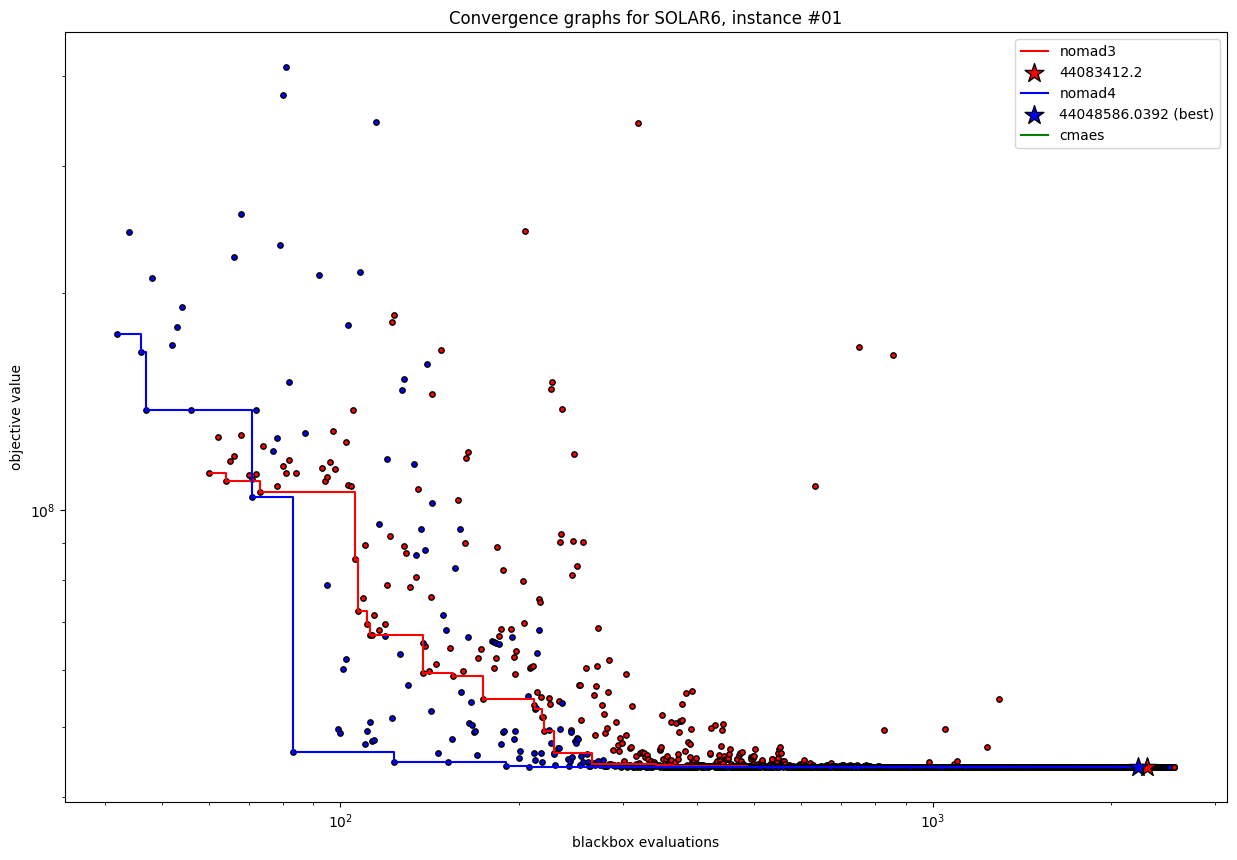

In [14]:
#-----------------------------------------#
#  to plot a specific convergence graphs  #
#-----------------------------------------#
import matplotlib.pyplot as plt

Run.n=5
Run.m=6

fig,ax = plt.subplots(figsize=(15,10))

instance="01"

convergence_graphs(ax,instance,all_pts=True,plot_best=True)

ax.set_title("Convergence graphs for SOLAR6, instance #"+instance)
ax.legend()

plt.xlabel('blackbox evaluations')
plt.ylabel('objective value')

ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_xlim(0, 3500)
#ax.set_ylim(0.43965E8, 0.4398E8)

plt.show()


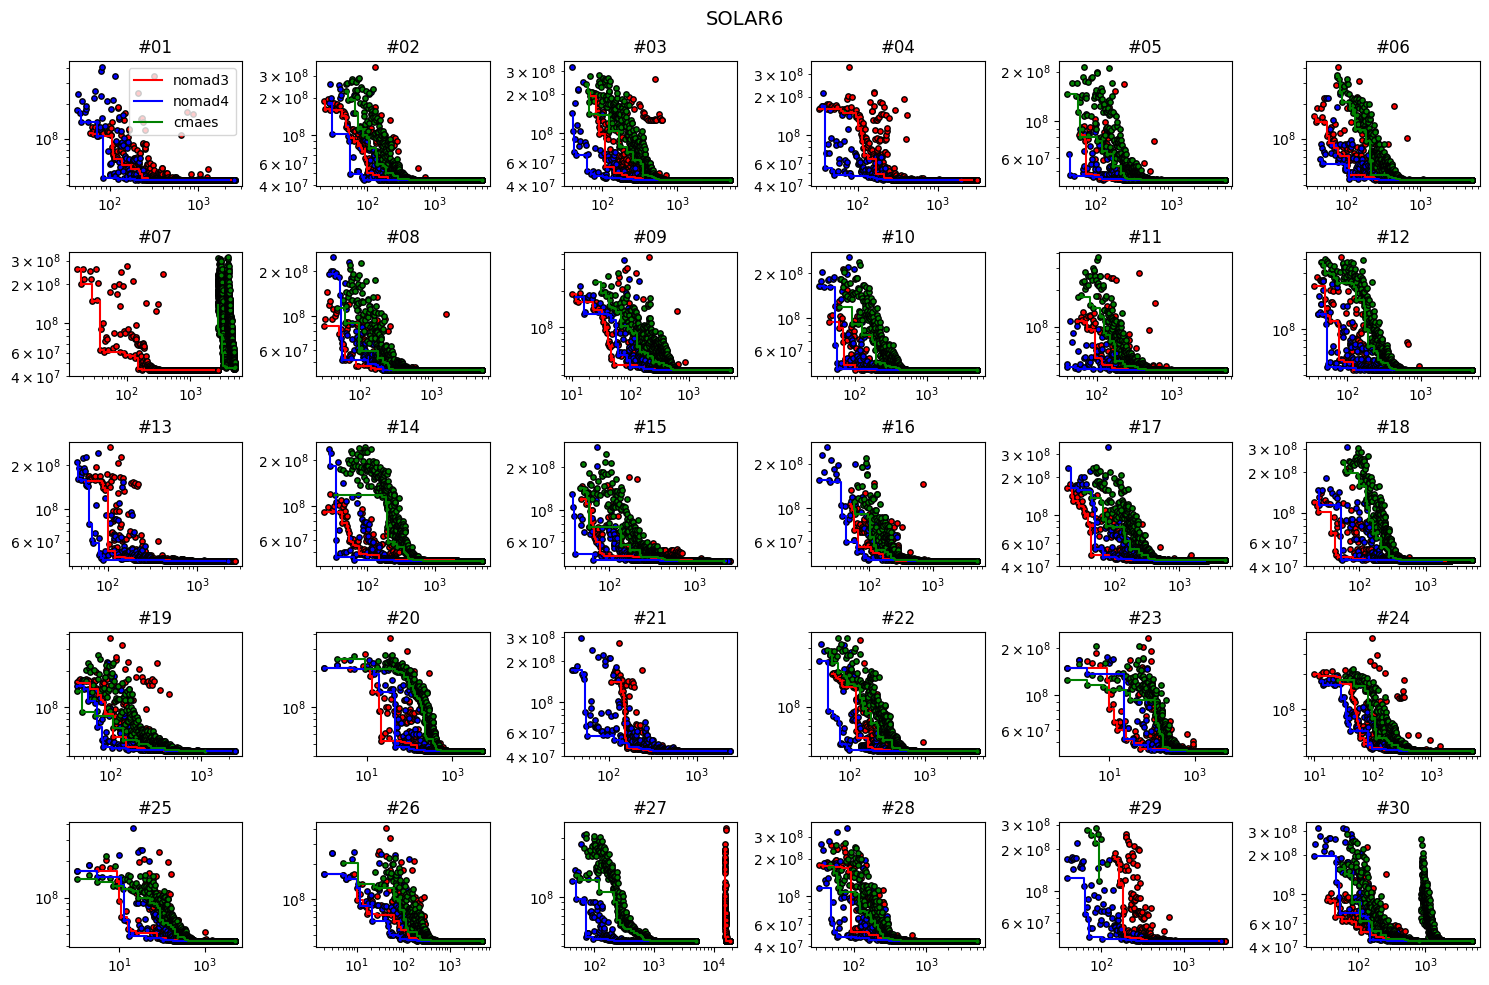

In [15]:
#---------------------------------#
#  to plot 30 convergence graphs  #
#---------------------------------#
import matplotlib.pyplot as plt

Run.n=5
Run.m=6

fig,ax = plt.subplots(nrows=5, ncols=6, figsize=(15,10))

all_pts = True

k=1
for i in range(5):
    for j in range(6):
        instance="0"
        if k > 9:
            instance=""
        instance=instance+str(k)
        convergence_graphs(ax[i][j],instance,all_pts,plot_best=False)
        ax[i][j].set_title("#"+instance)
        #ax[i][j].legend()
        ax[i][j].set_xscale('log')
        ax[i][j].set_yscale('log')
        k=k+1
ax[0][0].legend()

fig.suptitle("SOLAR6", fontsize=14)
fig.tight_layout()
plt.show()


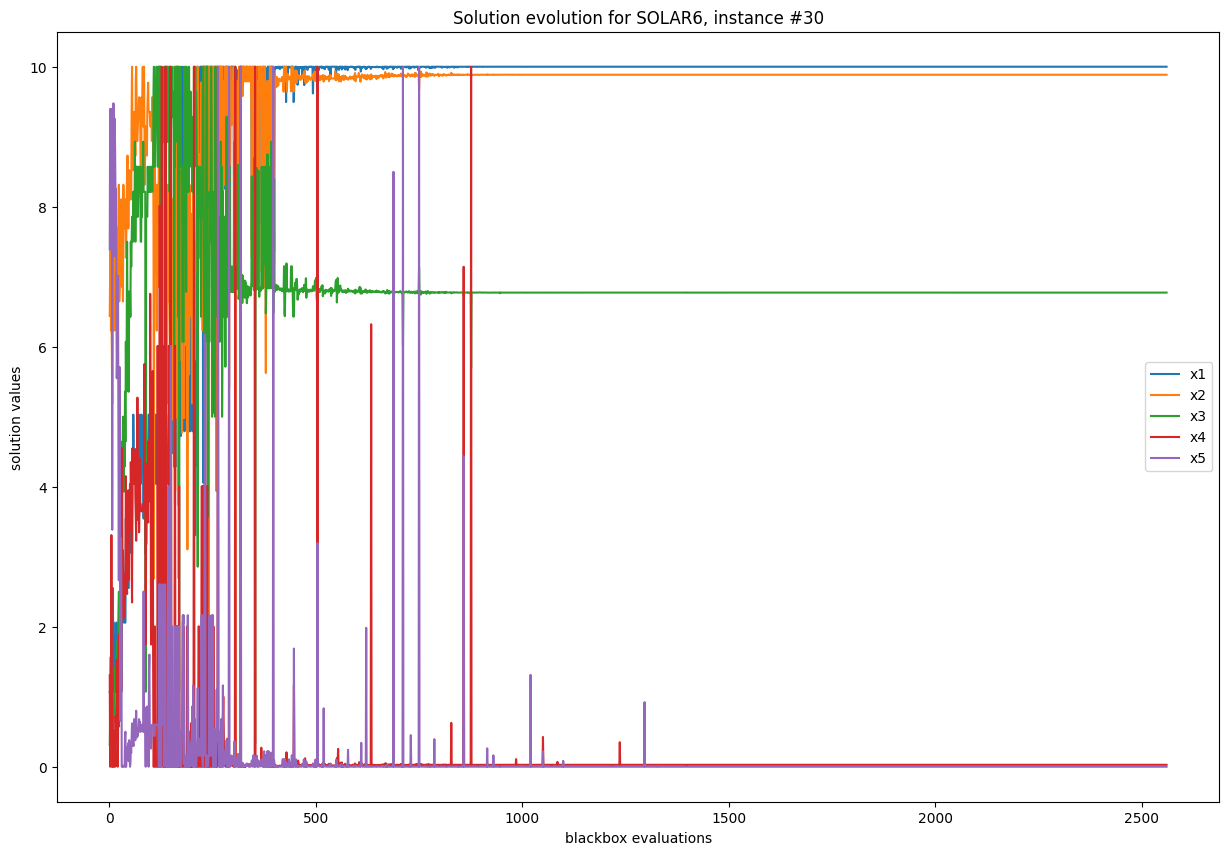

In [16]:
#----------------------------------------------------------#
#  to show the evolution of the solutions for a given run  #
#----------------------------------------------------------#
import matplotlib.pyplot as plt

Run.n=5
Run.m=6

# scaling: [lb,ub] --> [l,u]:
def scale ( x, lb, ub, l, u ):   

    for i in range(len(x)):
        x[i]=x[i]-lb
        x[i]=x[i]/(ub-lb)
        x[i]=x[i]*(u-l)+l


lb=[793.0,  2.0,  2.0, 0.01, 0.01]
ub=[995.0, 50.0, 30.0, 5.00, 5.00]

#run=Run("./runs/cmaes/cmaes_01.txt","cmaes")
run=Run("./runs/nomad3/nomad3_01.txt","cmaes")
#run.display()

bbe,f,x=run.get_all_evals()

x1=[]
x2=[]
x3=[]
x4=[]
x5=[]

for i in bbe:
    x1.append(x[int(i)-1][0])
    x2.append(x[int(i)-1][1])
    x3.append(x[int(i)-1][2])
    x4.append(x[int(i)-1][3])
    x5.append(x[int(i)-1][4])

l =  0.0
u = 10.0

scale ( x1, lb[0], ub[0], l, u )
scale ( x2, lb[1], ub[1], l, u )
scale ( x3, lb[2], ub[2], l, u )
scale ( x4, lb[3], ub[3], l, u )
scale ( x5, lb[4], ub[4], l, u )

fig,ax = plt.subplots(figsize=(15,10))

ax.plot(bbe,x1,label="x1")
ax.plot(bbe,x2,label="x2")
ax.plot(bbe,x3,label="x3")
ax.plot(bbe,x4,label="x4")
ax.plot(bbe,x5,label="x5")

ax.set_title("Solution evolution for SOLAR6, instance #"+instance)
ax.legend()

plt.xlabel('blackbox evaluations')
plt.ylabel('solution values')

plt.show()



In [18]:
#---------------------------#
#  to compute the profiles  #
#---------------------------#
def compute_profiles ( runs, nb_pts, tau ):

    best_f=nb_instances*[1E20]
    overall_best_f=1E20
    overall_best_x=Run.n*[1E20]

    maxbbe=-1

    # compute best solutions for each instance:
    # print("\nbest solutions for all runs:\n")
    for i in range(nb_instances):
        for a in range(nb_algos):
                
            #display_point(runs[i][a].best_x,runs[i][a].best_f,"Run["+str(i)+"]["+algo_names[a]+"]")
            #print("\n",end="")
            
            if runs[i][a].max_bbe > maxbbe:
                maxbbe=runs[i][a].max_bbe

            if runs[i][a].best_f < best_f[i]:
                best_f[i]=runs[i][a].best_f
            if runs[i][a].best_f < overall_best_f:
                overall_best_f=runs[i][a].best_f
                overall_best_x=runs[i][a].best_x


    #print("\nbest solution values for each instance:\n")
    for i in range(nb_instances):
        #print("instance #",i+1,": best_f=",best_f[i],sep="")
        assert ( best_f[i] != 1E20 ) # if true: no solution for instance #(i+1)

    #print("\noverall best x=",overall_best_x, " overall best_f=",overall_best_f)

    # compute tps:
    for i in range(nb_instances):
        for a in range(nb_algos):
            runs[i][a].compute_tps(fL=best_f[i],tau=tau)

    # compute rps:
    maxrps=-1.0
    for i in range(nb_instances):
        mintps=1E20
        for a in range(nb_algos):
            if runs[i][a].tps < mintps:
                mintps=runs[i][a].tps
        if mintps != 1E20 and mintps != 0.0:
            for a in range(nb_algos):
                if runs[i][a].tps != 1E20:
                    runs[i][a].rps=runs[i][a].tps/mintps
                    if runs[i][a].rps > maxrps:
                        maxrps=runs[i][a].rps
                else:
                    runs[i][a].rps=1E20
        else:
            for a in range(nb_algos):
                runs[i][a].rps=1E20

    # display tps and rps values:
    # print("\ntps and tps values:\n")
    # for i in range(nb_instances):
    #     for a in range(nb_algos):
    #         print("[i=",i,"][a=",algo_names[a],"]: tps=",runs[i][a].tps," rps=",runs[i][a].rps)
    # print("\nnax_rps=",maxrps)

    # compute performance profiles: rho[algo][alpha]
    alphas=np.linspace(1.0, maxrps*1.1, nb_pts)
    rho=np.full((nb_algos,nb_pts),0.0)

    for k in range(nb_pts):
        for a in range(nb_algos):
            cnt=0
            for i in range(nb_instances):
                if runs[i][a].rps <= alphas[k]:
                    cnt=cnt+1
            rho[a][k]=(1.0*cnt)/nb_instances
            
    # print("alpha=",alphas)
    # print("rho[0]=",rho[0])
    # print("rho[1]=",rho[1])
    # print("rho[2]=",rho[2])


    # compute data profiles: d[algo][kappa]
    kappas=np.linspace(0.0, (maxbbe/(Run.n+1))*1.1, nb_pts)
    d=np.full((nb_algos,nb_pts),0.0)
    for k in range(nb_pts):
        for a in range(nb_algos):
            cnt=0
            for i in range(nb_instances):
                if runs[i][a].tps/(Run.n+1.0) <= kappas[k]:
                    cnt=cnt+1
            d[a][k]=(1.0*cnt)/nb_instances

    # print("kappas=",kappas)
    # print("d[0]=",d[0])
    # print("d[1]=",d[1])
    # print("d[2]=",d[2])

    return alphas, kappas, rho, d

In [19]:
#----------------------------------------#
#  to draw the profiles for a given tau  #
#----------------------------------------#
def plot_profiles ( axpp, axdp, alphas, kappas, rho, d, tau ):

    # plot the performance profiles:
    # axpp.scatter(alphas,rho[0],color='red',edgecolor='black',s=15)
    # axpp.scatter(alphas,rho[1],color='blue',edgecolor='black',s=15)
    # axpp.scatter(alphas,rho[2],color='green',edgecolor='black',s=15)
    axpp.step(alphas,rho[0],color='red'  ,label='nomad3',where='post')
    axpp.step(alphas,rho[1],color='blue' ,label='nomad4',where='post')
    axpp.step(alphas,rho[2],color='green',label='cmaes' ,where='post')
    axpp.set_xlim(alphas[0], alphas[-1])
    axpp.set_title("tau="+str(tau))
    axpp.legend()
    axpp.set_xlabel("alpha")
    axpp.set_ylabel("performance profiles: ratio of instances")


    # plot the data profiles:
    # axdp.scatter(kappas,d[0],color='red',edgecolor='black',s=15)
    # axdp.scatter(kappas,d[1],color='blue',edgecolor='black',s=15)
    # axdp.scatter(kappas,d[2],color='green',edgecolor='black',s=15)
    axdp.step(kappas,d[0],color='red',label='nomad3',where='post')
    axdp.step(kappas,d[1],color='blue',label='nomad4',where='post')
    axdp.step(kappas,d[2],color='green',label='cmaes',where='post')
    axdp.set_xlim(kappas[0], kappas[-1])
    axdp.set_title("tau="+str(tau))
    axdp.legend()
    axdp.set_xlabel("groups of (n+1) evaluations")
    axdp.set_ylabel("data profiles: ratio of instances")


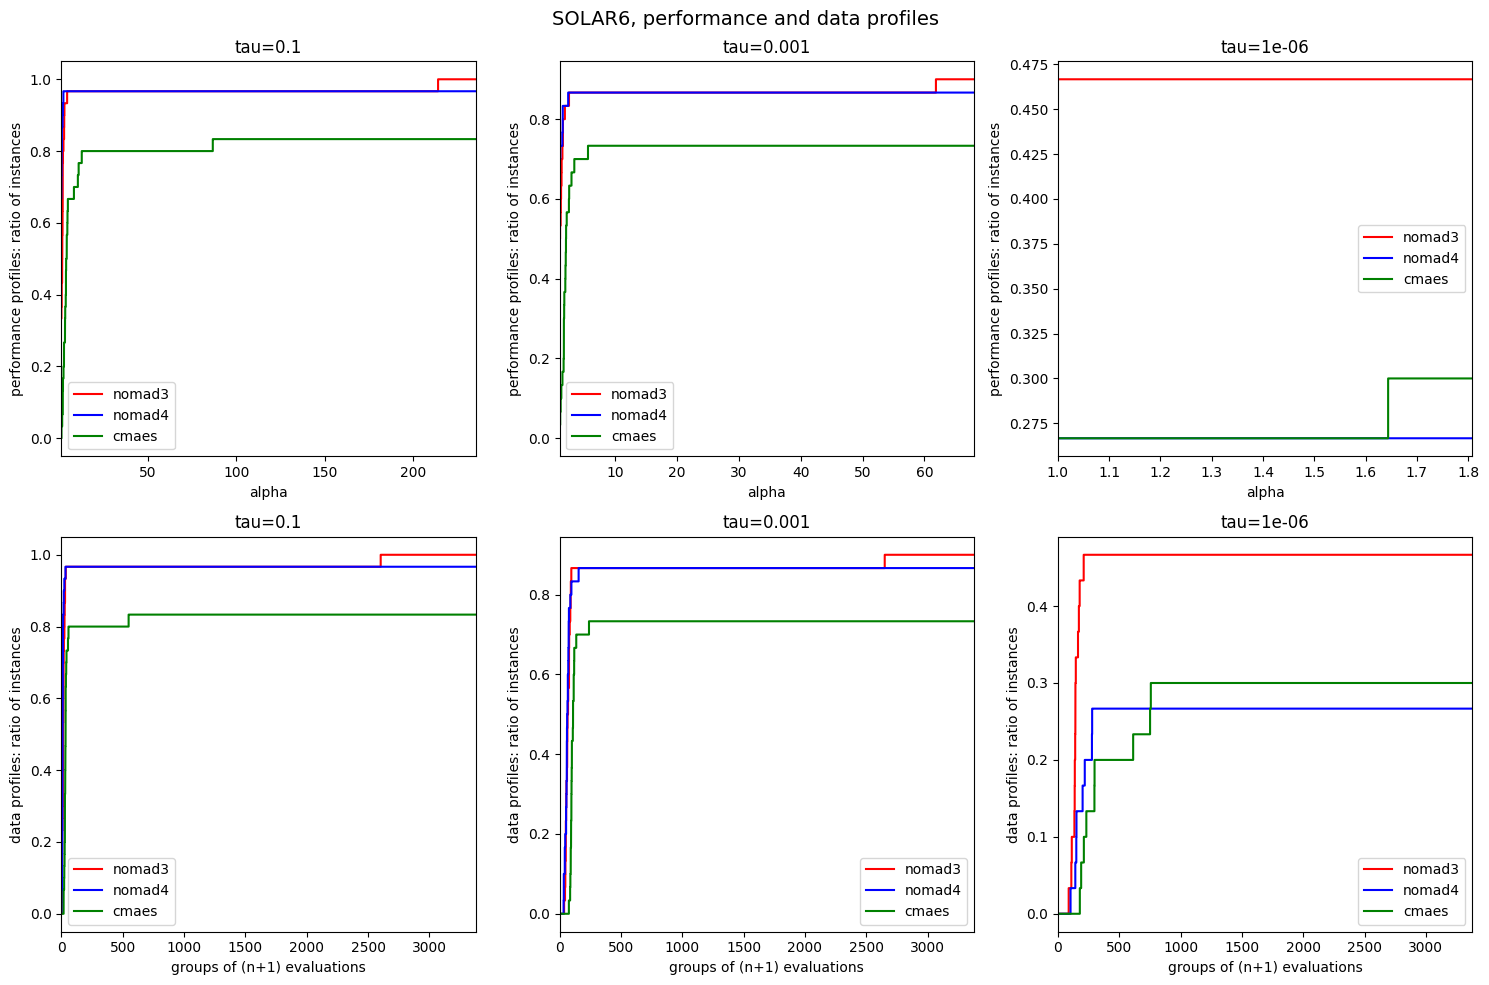

In [20]:
#------------#
#  profiles  #
#------------#
import matplotlib.pyplot as plt

Run.n=5
Run.m=6

nb_instances=30
nb_algos=3
algo_names=['nomad3','nomad4','cmaes']
algo_types=['nomad' ,'nomad' ,'cmaes']

# store all runs: runs[i][a]: Run of algorithm a on instance i:
runs = [[Run("./runs/"+algo_names[a]+"/"+algo_names[a]+"_"+(str(i+1) if i >= 9 else "0"+str(i+1))+".txt",algo_types[a]) for a in range(nb_algos)] for i in range(nb_instances)]

# compute the performance and data profiles for three values of tau:

nb_pts=10000

tau1=1E-1
tau2=1E-3
tau3=1E-6
alphas1, kappas1, rho1, d1 = compute_profiles ( runs, nb_pts, tau1 )
alphas2, kappas2, rho2, d2 = compute_profiles ( runs, nb_pts, tau2 )
alphas3, kappas3, rho3, d3 = compute_profiles ( runs, nb_pts, tau3 )

fig,ax = plt.subplots(nrows=2, ncols=3, figsize=(15,10))

plot_profiles(ax[0][0], ax[1][0], alphas1, kappas1, rho1, d1, tau1)
plot_profiles(ax[0][1], ax[1][1], alphas2, kappas2, rho2, d2, tau2)
plot_profiles(ax[0][2], ax[1][2], alphas3, kappas3, rho3, d3, tau3)

fig.suptitle("SOLAR6, performance and data profiles", fontsize=14)
fig.tight_layout()

plt.show()



